In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
mpl.rcParams['axes.grid'] = False

In [24]:
# from plotter import plot_history, plot_predictions, plot_prediction
def score(history,predictions):
    r2 = r2_score(history,predictions)
    rmse = np.sqrt(mean_squared_error(history,predictions))
    print(f'r2:{r2},rmse:{rmse}')

def plot_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, label='Train Loss')
  plt.plot(epochs, val_loss, label='Valid Loss')
  plt.legend()
  plt.title('History Loss')
  plt.xlabel('Epochs')
  plt.show()

def plot_predictions(real, predictions=None, label='Test'):
  time_steps = range(0, len(real))

  if predictions is None:
    predictions = [] # [real[0]]

    for i in range(0, len(real)):
      predictions.append(np.mean(real[:i+1]))
    
    plt.plot(time_steps, predictions, 'y', label='Mean') # 'yo-'
  else:
      plt.plot(time_steps, predictions, 'g', label='Predictions')

  plt.plot(time_steps, real, 'b', label='Real')
  #plt.xlim([time_steps[0], (future+5)*2])
  plt.title(f'{label} Set Predictions')
  plt.legend()
  plt.show()
  
  score(real, predictions)

def plot_prediction(history, truth, prediction=None, label='Test'):
  future = 0
  time_steps = list(range(-history.shape[0], 0))
  plt.plot(time_steps, history, '.-', label='History')
  plt.plot(future, truth, 'rx', markersize=10, label='Truth')

  if prediction is None:
    prediction = np.mean(history)
    plt.plot(future, prediction, 'go', markersize=10, label='Mean')
  else:
    plt.plot(future, prediction, 'go', markersize=10, label='Prediction')
  
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')

  plt.title(f'{label} Single Prediction')
  plt.show()

In [3]:
# Data

class StockData:
  def __init__(self, index='nasdaq', time_window='daily', features=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume'], train_feature='5. adjusted close'):
    
    self.name = index

    stocks = pd.read_csv('./data/Nasdaq_100_stocks.csv')
    stocks = stocks['Names']

    if index is 'test':
      stocks = stocks[:10]

    self.stocks = stocks
    self.time_window = time_window
    self.features = features
    self.train_feature = train_feature
    self.train_feature_index = features.index(train_feature)

    self.train_split = 0.9
    self.history_size = 20
    self.target_size = 0 # how much in future future_target
    self.step = 1 # how many values to step / skip
    self.single_step = True

  def csv_to_dataset(self, symbol='MSFT'):
    df = pd.read_csv(f'./data/{symbol}_{self.time_window}.csv')

    data = df[self.features]
    data.index = df['date']
    
    return data

  def get_dataset(self, stocks=[], normalise='keras'):

    dataset = []

    for stock in stocks:
      df = self.csv_to_dataset(stock)
      data = df.values

      if normalise == 'keras':
        # tf.keras.utils.normalize(data, axis=-1, order=2)
        data = tf.keras.utils.normalize(data, axis=0, order=2) 
      elif normalise == 'manual':
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
        data = (data-data_mean)/data_std
  
      dataset.append(data)

    return dataset
    
  def split(self, train_split=0.9):
    split = int(self.stocks.shape[0] * train_split)

    train_stocks = self.stocks[:split]
    val_stocks = self.stocks[split:]

    train_dataset = self.get_dataset(train_stocks)
    val_dataset = self.get_dataset(val_stocks)

    return train_dataset, val_dataset

  def multivariate(self, stocks, start_time_index=0, end_time_index=None):
    history_size = self.history_size
    target_size = self.target_size
    train_feature_index = self.train_feature_index

    data = []
    labels = []

    for dataset in stocks:
        target = dataset[:, train_feature_index]
        start_index = start_time_index + history_size
        end_index = end_time_index
        
        if end_index is None:
            end_index = len(dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, 1) #step = 1
            data.append(dataset[indices])
            labels.append(target[i+target_size])

    return np.array(data), np.array(labels)
  
  def get_datasets(self, train_split=0.9):
    train_dataset, val_dataset = data.split(train_split)
    
    x_train, y_train = data.multivariate(train_dataset)
    x_val, y_val = data.multivariate(val_dataset)
    return x_train, y_train, x_val, y_val

In [4]:
#Load Stocks
data = StockData('test')

print(f'name: {data.name} \nstocks:{data.stocks.shape[0]} \nhistory_size: {data.history_size}\nfeatures: {data.features} \ntime_window: {data.time_window} \ntrain_feature: {data.train_feature} \ntrain_feature_index: {data.train_feature_index}')

name: test 
stocks:10 
history_size: 20
features: ['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume'] 
time_window: daily 
train_feature: 5. adjusted close 
train_feature_index: 4


In [5]:
# Get Data

train_dataset, val_dataset = data.split()

x_train, y_train = data.multivariate(train_dataset)
x_val, y_val = data.multivariate(val_dataset)
input_shape = x_train.shape[-2:]

print(f'input: {input_shape}')
print(f'train shapes: {x_train.shape}, {y_train.shape}')
print(f'val shapes: {x_val.shape}, {y_val.shape}')
# train_dataset.describe()

input: (20, 6)
train shapes: (38836, 20, 6), (38836,)
val shapes: (5013, 20, 6), (5013,)


In [6]:
# Load Model Basics

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras import optimizers

In [7]:
# benchmark model

model_lr = Sequential()
model_lr.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
model_lr.add(Dense(100, activation='relu'))
model_lr.add(Dense(100, activation='relu'))
model_lr.add(Dense(1))
optimizer_lr = optimizers.RMSprop(0.001)
model_lr.compile(loss='mae',optimizer=optimizer_lr, metrics=['mse'])
model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 22,301
Trainable params: 22,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
# MODELS
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=x_train.shape[-2:], return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64)) #, activation='sigmoid'
model_lstm.add(Dense(1)) # , activation='linear'

optimizer_lstm = optimizers.Adam(0.001)
model_lstm.compile(loss='mae',optimizer=optimizer_lstm,metrics=['mse'])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 64)            18176     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 32,769
Trainable params: 32,769
Non-trainable params: 0
__________________________________________________

5013/5013 [==============================] - 0s 19us/sample - loss: 8.1520e-04 - mse: 8.2458e-07
[0.0008151986507196169, 8.245845e-07]


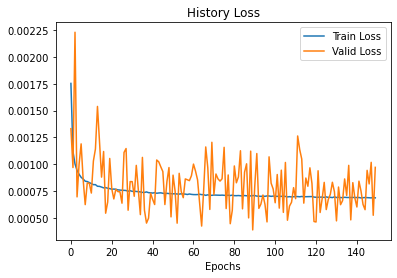

In [9]:
# Train LR

lr_history = model_lr.fit(x_train, y_train, epochs=150, shuffle=True, validation_split=0.1, verbose=0)
print(model_lr.evaluate(x_val, y_val))
plot_history(lr_history)

Train on 34952 samples, validate on 3884 samples
Epoch 1/100
34952/34952 [==============================] - 15s 433us/sample - loss: 0.0020 - mse: 9.2793e-06 - val_loss: 0.0019 - val_mse: 5.1887e-06
Epoch 2/100
34952/34952 [==============================] - 13s 370us/sample - loss: 0.0015 - mse: 5.4740e-06 - val_loss: 0.0017 - val_mse: 3.7976e-06
Epoch 3/100
34952/34952 [==============================] - 13s 375us/sample - loss: 0.0013 - mse: 4.6951e-06 - val_loss: 7.8549e-04 - val_mse: 9.4386e-07
Epoch 4/100
34952/34952 [==============================] - 14s 390us/sample - loss: 0.0013 - mse: 4.5102e-06 - val_loss: 7.6088e-04 - val_mse: 8.8057e-07
Epoch 5/100
34952/34952 [==============================] - 14s 388us/sample - loss: 0.0013 - mse: 4.3591e-06 - val_loss: 7.3966e-04 - val_mse: 7.8427e-07
Epoch 6/100
34952/34952 [==============================] - 13s 379us/sample - loss: 0.0012 - mse: 3.9962e-06 - val_loss: 4.7469e-04 - val_mse: 4.4775e-07
Epoch 7/100
34952/34952 [==========

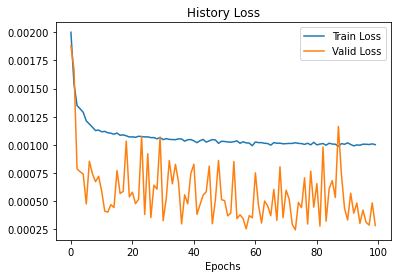

In [10]:
# Train LSTM
lstm_history = model_lstm.fit(x_train, y_train, epochs=100, shuffle=True, validation_split=0.1, verbose=1)

print(model_lstm.evaluate(x_val, y_val))
plot_history(lstm_history)

In [27]:
# Test Plots



def plot_model_predictions(model=None, label='Mean', start=0, steps=500, x=x_val, y=y_val ):
    history = y[start:steps] 

    predictions = None

    if model is not None:
        predictions = model.predict(x[start:steps]).flatten() 
    
    #print(history.shape, predictions.shape)
    plot_predictions(history, predictions, label)
    

def plot_model_prediction(model, label, i=None, x=x_val, y=y_val):
    if i is None:
        i = np.random.randint(0, len(x))
    
    prediction = model.predict(x)[i][0] # model.predict(x[i]) 
    history = x[i][:, data.train_feature_index]
    
    #print(history, prediction, y[i])
    plot_prediction(history, y[i], prediction, label)
    
def plot_model_both(lr, lstm, x=x_val, y=y_val, i=None):
    if i is None:
        i = np.random.randint(0, len(x))

    truth = y[i]
    history = x[i][:, data.train_feature_index]
    future = 0
    time_steps = list(range(-history.shape[0], 0))

    lr_prediction = lr.predict(x)[i][0] 
    lstm_prediction = lstm.predict(x)[i][0]

    plt.plot(time_steps, history, '.-', label='History')
    plt.plot(future, truth, 'rx', markersize=10, label='Truth')

    plt.plot(future, lr_prediction, 'go', markersize=10, label='LR')
    plt.plot(future, lstm_prediction, 'yo', markersize=10, label='LSTM')
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')

    plt.title('Prediction Comparison')
    plt.show()

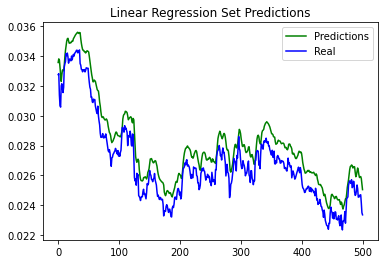

r2:0.79238138931953,rmse:0.0012796888910814436


In [17]:
# Plot Linear Regression

plot_model_predictions(model_lr, 'Linear Regression')

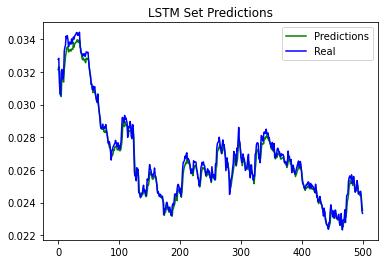

r2:0.9840881981404725,rmse:0.0003542671966026326
r2:0.9840881981404725,rmse:0.0003542671966026326


In [26]:
# Plot LSTM

plot_model_predictions(model_lstm, 'LSTM')

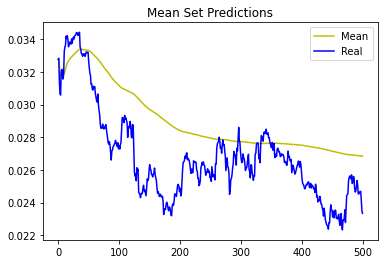

r2:0.0068009325984372815,rmse:0.0027989130764170403


In [28]:

plot_model_predictions()

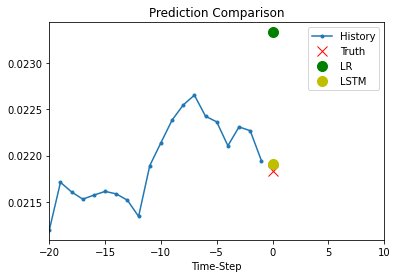

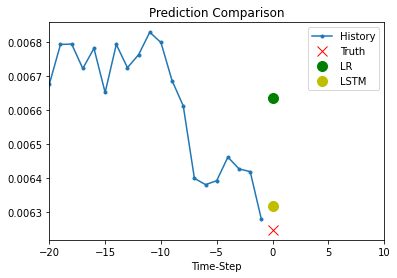

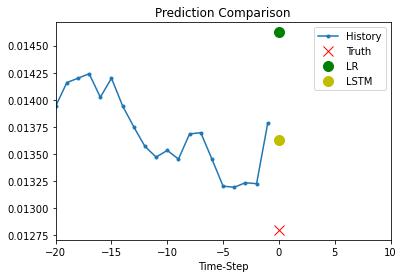

In [14]:
# Compare Single

for i in range(0, 3):
    plot_model_both(model_lr, model_lstm)

